***Task Overview***

As a researcher, I would like to find out the impact from contentious parameters (`market.liquidity.probabilityOfTrading.tau.scaling`), so that I can set a reasonable default value for them.

`market.liquidity.probabilityOfTrading.tau.scaling` is a scaling parameter which is used to scale $\tau$ in risk model in calculation of probability of trading calculation so to eventually adjust the pegged volume for liquidity provider. 

Change of `market.liquidity.probabilityOfTrading.tau.scaling` will immediately change the scaling parameter for $\tau$
, hence will change the probability of trading in LP orders, as well as the margin requirement of the LPs, and eventually change the PnL of the LPs. 

***Input Metrics***

- simulated market is **ETH/USD** with market decimal place **mdp = 3**, asset decimal place **adp = 5** and position decimal place **pdp = 2**

- initial mid-price of **ETH/USD** is **$1123.11** (the average price on 15/06/2022)

- run **Trials=5** trials for each test

- each trial has **Time = 86400 s = 24 h** with interval of **5 min**

- target simulated daily traded notional is **$694,928,100.62**

- LP commitment is set to be a reasonable constant number in the simulation to avoid liquidity auction

- network parameter `market.liquidity.probabilityOfTrading.tau.scaling` is set to be [1, 10, 100]


***Output Metrics***

Under different network parameter `market.liquidity.probabilityOfTrading.tau.scaling`:

- Output 1: LP postion

- Output 2: average of LP margin account

- Output 3: average of LP bond account

- Output 4: average of LP's **general PnL** 

- Output 5: average of **traded notional**

- Output 6: average of market **open interest**

- Output 7: average of **target stake** of market 


### A comparison with the result from 'IdealMarketMakerV2'

In [13]:
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../../../parameter-tests/')
from parameter.experiment import FILE_PATTERN

with open('run_config.json') as d:
    setting = json.load(d)

num_of_paravalues = len(setting['tested_values'])

data = []

for _ in range(num_of_paravalues):
    file_path = FILE_PATTERN.format(
        param_name=setting['parameter_tested'], param_value=setting['tested_values'][_]
    )
    data.append(pd.read_csv(file_path))

# if number of sim under each parameter is larger than 1
if setting['num_runs'] > 1:
    data_ave = []
    for _ in range(num_of_paravalues):
        data_ave.append(data[_].groupby(data[_]["Time Step"]).mean())
else:
    data_ave =[]
    for _ in range(num_of_paravalues):
        data_ave.append(data[_].set_index(data[_]['Time Step']))      

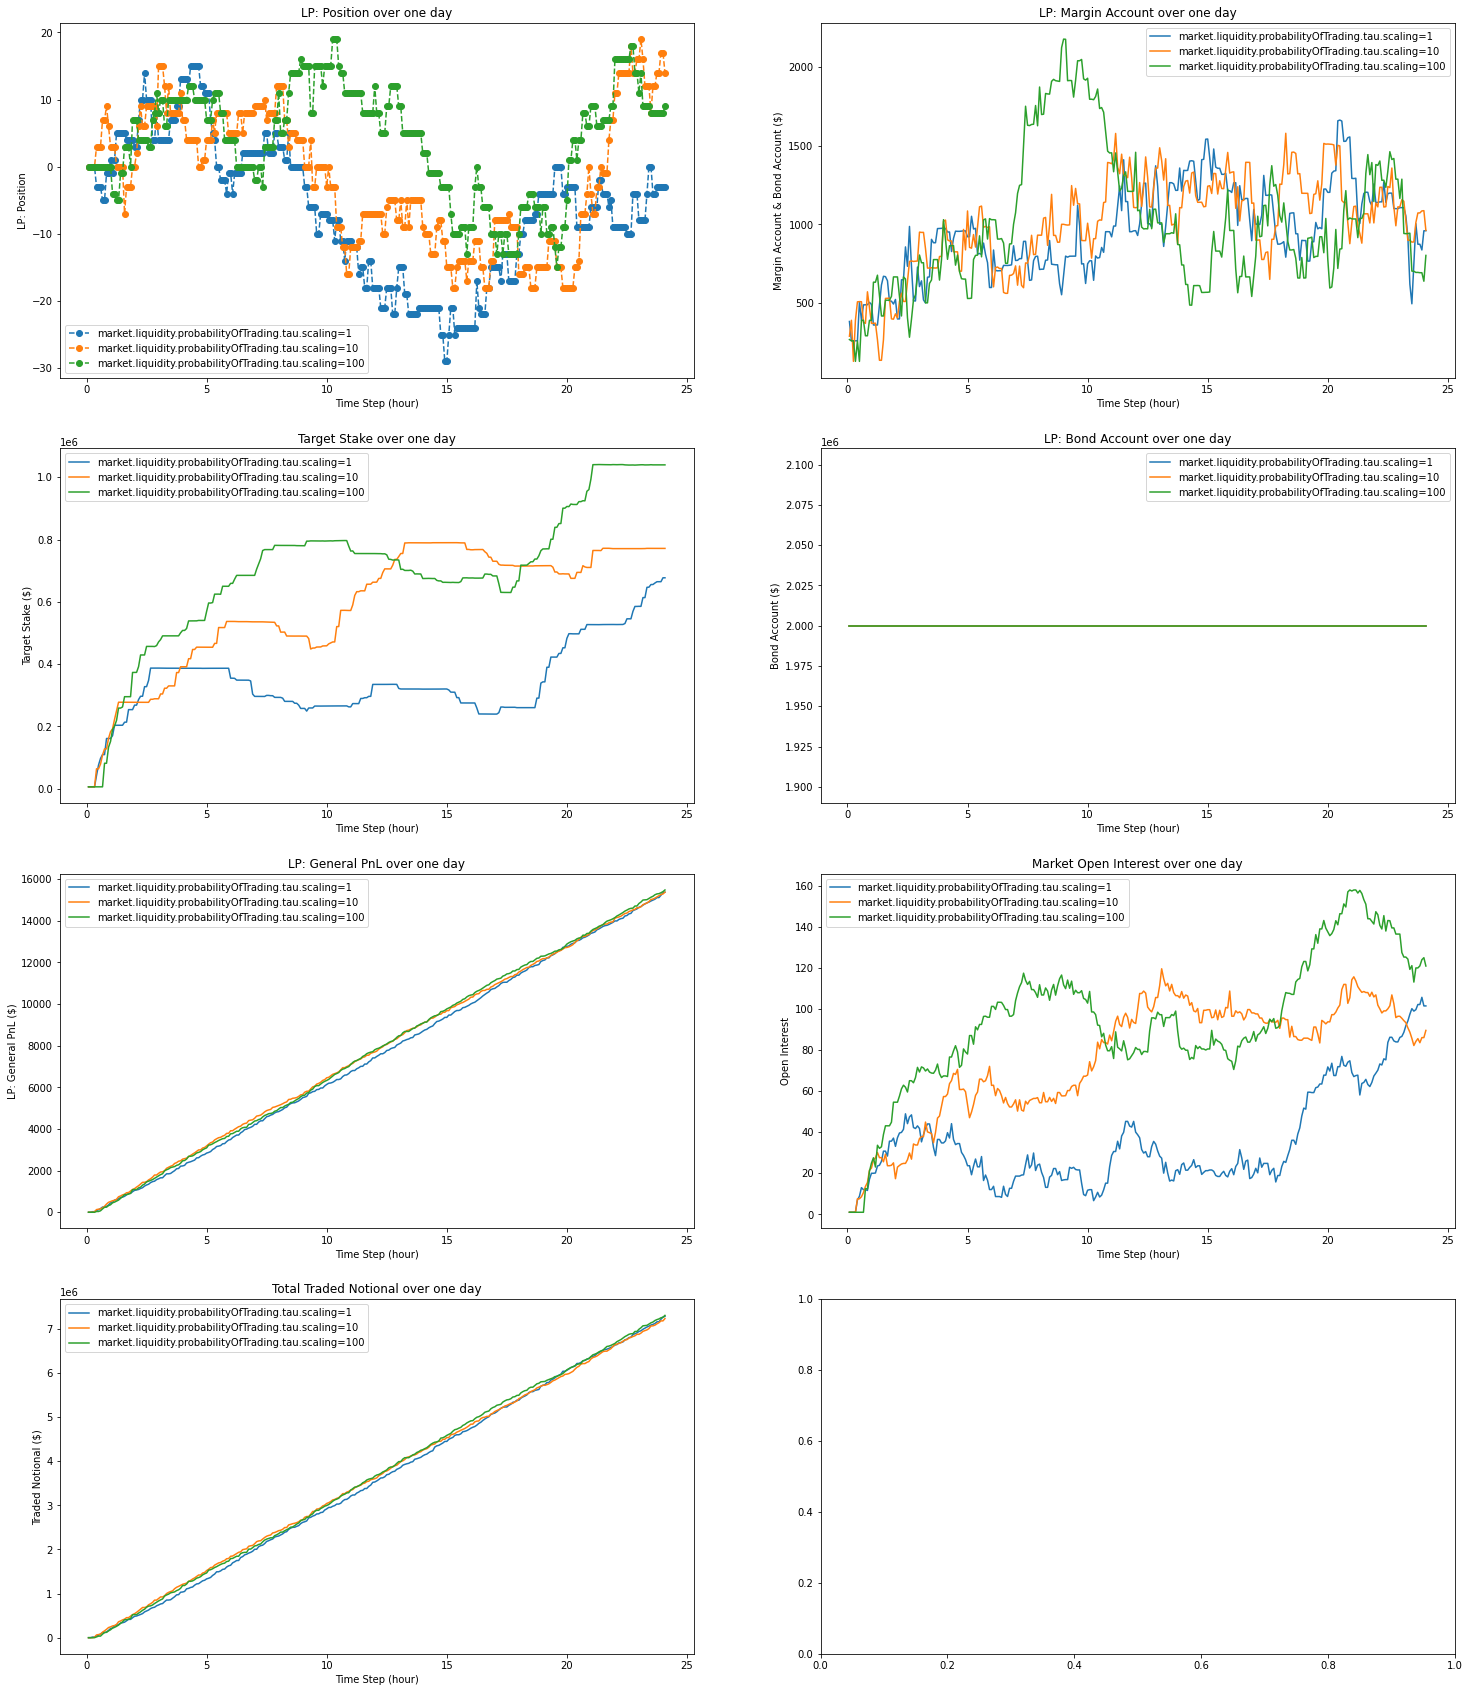

In [14]:
# Plot the optimal strategy
fig,ax = plt.subplots(4,2,figsize=(25,30))

# Since the interval of sim is 5 min
dt = 5 / 60

# Plot LP: Position over one day
for _ in range(num_of_paravalues):
    ax[0,0].plot(data_ave[_].index * dt,data[_][data[_]['Iteration'] == 0]['LP: Position'],'o--',label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
# ax[0,0].plot(ave_tau_1.index * dt,data_tau_1['LP: Position'],'o--',label="tauscaling=1")
# ax[0,0].plot(ave_tau_10.index * dt,data_tau_10['LP: Position'],'o--',label="tauscaling=10")
# ax[0,0].plot(ave_tau_100.index * dt,data_tau_100['LP: Position'],'o--',label="tauscaling=100")
ax[0,0].set_title('LP: Position over one day')
ax[0,0].set_xlabel("Time Step (hour)")
ax[0,0].set_ylabel("LP: Position")
ax[0,0].legend()

# Plot LP: Margin Account 
for _ in range(num_of_paravalues):
    ax[0,1].plot(data_ave[_].index * dt,data_ave[_]['LP: Margin Account'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[0,1].set_title('LP: Margin Account over one day')
ax[0,1].set_xlabel("Time Step (hour)")
ax[0,1].set_ylabel("Margin Account & Bond Account ($)")
ax[0,1].legend()

# Bond Account
for _ in range(num_of_paravalues):
    ax[1,1].plot(data_ave[_].index * dt,data_ave[_]['LP: Bond Account'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[1,1].set_title('LP: Bond Account over one day')
ax[1,1].set_xlabel("Time Step (hour)")
ax[1,1].set_ylabel("Bond Account ($)")
ax[1,1].legend()

# Plot target stake in market
for _ in range(num_of_paravalues):
    ax[1,0].plot(data_ave[_].index * dt,data_ave[_]['Target Stake'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[1,0].set_title('Target Stake over one day')
ax[1,0].set_xlabel("Time Step (hour)")
ax[1,0].set_ylabel("Target Stake ($)")
ax[1,0].legend()

# Plot LP: General PnL
for _ in range(num_of_paravalues):
    ax[2,0].plot(data_ave[_].index * dt,data_ave[_]['LP: GeneralPnl'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[2,0].set_title('LP: General PnL over one day')
ax[2,0].set_xlabel("Time Step (hour)")
ax[2,0].set_ylabel("LP: General PnL ($)")
ax[2,0].legend()

# Plot Market Open Interest
for _ in range(num_of_paravalues):
    ax[2,1].plot(data_ave[_].index * dt,data_ave[_]['Market Open Interest'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[2,1].set_title('Market Open Interest over one day')
ax[2,1].set_xlabel("Time Step (hour)")
ax[2,1].set_ylabel("Open Interest")
ax[2,1].legend()

# Plot Total Traded Notional
for _ in range(num_of_paravalues):
    ax[3,0].plot(data_ave[_].index * dt,data_ave[_]['Total Traded Notional'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[3,0].set_title('Total Traded Notional over one day')
ax[3,0].set_xlabel("Time Step (hour)")
ax[3,0].set_ylabel("Traded Notional ($)")
ax[3,0].legend()

plt.show()

### Problems of the imperfect result

- solved: 
    - At each time step after one side of market order arriving, midprice will locate at a "wrong" place, causing LP always put a undesired depth at one side. (Post limit order at a fixed level)

- in progress:
    - Each time when updating the ideal LOB, the order from the background environment will be crossed with LP order, causing the environment not ideal and LP's undesired trading. 